This Project Implements an item-based collaborative filter to suggest movies / songs / products to a user based on historical data. 

In [26]:
#Library Imports:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
%matplotlib inline

In [2]:
#Importing the movie dataset
dataframe = pd.read_csv('Movie_Id_titles')

#Determine the shape of the dataframe
print('Dataframe containing movie data consists of {} rows and {} columns\n'.format(dataframe.shape[0], dataframe.shape[1]))

#Visualize the data by displaying some of the entries from dataframe
dataframe.head(10)

Dataframe containing movie data consists of 1682 rows and 2 columns



,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [3]:
#read the csv file
rating_dataframe = pd.read_csv(
    'u.data', 
    sep = '\t', 
    names =['user_id', 'item_id', 'rating', 'timestamp']   
)

#drop the timestamp column since it wont be relevant, choose axis = 1 to specify that we drop the entire column
rating_dataframe.drop(['timestamp'], axis=1, inplace = True)

#Determine the shape of the rating dataframe
print('Dataframe containing user data consists of {} rows and {} columns\n'.format(rating_dataframe.shape[0], rating_dataframe.shape[1]))

rating_dataframe.head(10)

Dataframe containing user data consists of 100003 rows and 3 columns



,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
5,22,377,1
6,244,51,2
7,166,346,1
8,298,474,4
9,115,265,2


In [4]:
#Get some useful information about the rating column
#This info is not relevant for user_id and item_id columns so we exclude them.
pd.set_option('float_format', '{:2f}'.format)
print('{}\n'.format(rating_dataframe['rating'].describe()))

#making sure that our dataset does not have null values
print('Below is the info required to verify that our data does not contain any null values:\n')
rating_dataframe.info()

count   100003.000000
mean         3.529864
std          1.125704
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

Below is the info required to verify that our data does not contain any null values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100003 non-null  int64
 1   item_id  100003 non-null  int64
 2   rating   100003 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [5]:
#combine information thats relevant from both dataframes, we use item_id as the selector
rating_dataframe = pd.merge(rating_dataframe, dataframe, on = 'item_id')

#verify the merge
print(rating_dataframe.shape)
rating_dataframe.head(1000)

#The result of this merge shows every single rating that every single user gave to every title they've watched

(100003, 4)


,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
1,290,50,5,Star Wars (1977)
2,79,50,4,Star Wars (1977)
3,2,50,5,Star Wars (1977)
4,8,50,5,Star Wars (1977)
...,...,...,...,...
995,245,133,2,Gone with the Wind (1939)
996,500,133,3,Gone with the Wind (1939)
997,43,133,4,Gone with the Wind (1939)
998,138,133,4,Gone with the Wind (1939)


In [6]:
#group the ratings given by title for example:
#notice that by the end of this we have 1664 rows that match the number of movies in the movie_dataframe

rating_dataframe.groupby('title')['rating'].describe()

#now we have every single movie on our data, 
#count shows how many times each movie was rated in total
#the mean shows the average rating
#the minimum rating is shown under min
#the maximum rating is shown under the max 

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.000000,2.333333,1.000000,1.000000,2.000000,2.000000,3.000000,4.000000
1-900 (1994),5.000000,2.600000,1.516575,1.000000,1.000000,3.000000,4.000000,4.000000
101 Dalmatians (1996),109.000000,2.908257,1.076184,1.000000,2.000000,3.000000,4.000000,5.000000
12 Angry Men (1957),125.000000,4.344000,0.719588,2.000000,4.000000,4.000000,5.000000,5.000000
187 (1997),41.000000,3.024390,1.172344,1.000000,2.000000,3.000000,4.000000,5.000000
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.000000,2.772727,1.008421,1.000000,2.000000,3.000000,3.000000,5.000000
"Young Poisoner's Handbook, The (1995)",41.000000,3.341463,1.237129,1.000000,3.000000,4.000000,4.000000,5.000000
Zeus and Roxanne (1997),6.000000,2.166667,0.983192,1.000000,1.250000,2.500000,3.000000,3.000000


In [7]:
#next we extrat the mean and count columns 
rating_dataframe_mean = rating_dataframe.groupby('title')['rating'].describe()['mean']
rating_dataframe_count = rating_dataframe.groupby('title')['rating'].describe()['count']

#join both of them in a new dataframe and add an index
ratings_mean_count_dataframe = pd.concat([rating_dataframe_count, rating_dataframe_mean], axis=1)
ratings_mean_count_dataframe.reset_index()

,title,count,mean
0,'Til There Was You (1997),9.000000,2.333333
1,1-900 (1994),5.000000,2.600000
2,101 Dalmatians (1996),109.000000,2.908257
3,12 Angry Men (1957),125.000000,4.344000
4,187 (1997),41.000000,3.024390
...,...,...,...
1659,Young Guns II (1990),44.000000,2.772727
1660,"Young Poisoner's Handbook, The (1995)",41.000000,3.341463
1661,Zeus and Roxanne (1997),6.000000,2.166667
1662,unknown,9.000000,3.444444


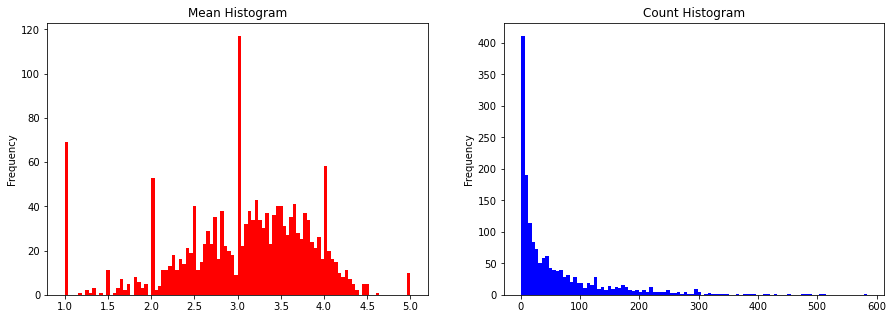

In [8]:
#Plot the histogram for the new dataframe:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figheight(5)
fig.set_figwidth(15)

axes[0].title.set_text('Mean Histogram')
axes[1].title.set_text('Count Histogram')

ratings_mean_count_dataframe['mean'].plot(bins = 100, kind = 'hist', color = 'red', ax=axes[0])
ratings_mean_count_dataframe['count'].plot(bins = 100, kind = 'hist', color = 'blue', ax=axes[1])

#Note that the mean histogram shows the mean rating of a particular movie ID 
#Note that the count histogram shows the count or how many times a particular movie ID has been rated

In [9]:
#select only movies that have a 5 star rating only 
ratings_mean_count_dataframe[ratings_mean_count_dataframe['mean'] == 5]

,count,mean
title,,
Aiqing wansui (1994),1.000000,5.000000
Entertaining Angels: The Dorothy Day Story (1996),1.000000,5.000000
"Great Day in Harlem, A (1994)",1.000000,5.000000
Marlene Dietrich: Shadow and Light (1996),1.000000,5.000000
Prefontaine (1997),3.000000,5.000000
"Saint of Fort Washington, The (1993)",2.000000,5.000000
Santa with Muscles (1996),2.000000,5.000000
Someone Else's America (1995),1.000000,5.000000
Star Kid (1997),3.000000,5.000000


In [10]:
#select the top 100 movies with highest rating count for example 
ratings_mean_count_dataframe.sort_values('count', ascending = False).head(100)

,count,mean
title,,
Star Wars (1977),584.000000,4.359589
Contact (1997),509.000000,3.803536
Fargo (1996),508.000000,4.155512
Return of the Jedi (1983),507.000000,4.007890
Liar Liar (1997),485.000000,3.156701
...,...,...
Aladdin (1992),219.000000,3.812785
Babe (1995),219.000000,3.995434
Volcano (1997),219.000000,2.808219


# Item-Based Collaborative Filtering on one movie only

In [11]:
#create a matrix 
uId_title_mtrx = rating_dataframe.pivot_table(index = 'user_id', columns = 'title', values = 'rating')
uId_title_mtrx
#note that the reason for nan values is that the specific user associated with the user ID did not provide a rating
#for that movie. 


title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,2.000000,5.000000,nan,nan,3.000000,4.000000,nan,nan,...,nan,nan,nan,5.000000,3.000000,nan,nan,nan,4.000000,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,1.000000,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,2.000000,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
940,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
941,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [12]:
#select the titanic movie and look at how many people have watched it and the rating the gave it
titanic = uId_title_mtrx['Titanic (1997)']
titanic.head(100)

user_id
0         nan
1         nan
2    5.000000
3         nan
4         nan
       ...   
95        nan
96        nan
97        nan
98        nan
99   5.000000
Name: Titanic (1997), Length: 100, dtype: float64

In [13]:
#Next we create a correlation between the movie titanic and the entire matrix
titanic_corr = pd.DataFrame(uId_title_mtrx.corrwith(titanic), columns = ['Correlation'])

/Users/firassawan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/firassawan/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [14]:
#then we add a column that shows how many times the movie has been viewed 
titanic_corr = titanic_corr.join(ratings_mean_count_dataframe['count'])

In [15]:
#The result shows how every single movie is correlated to the movie titanic along with how many times that movie 
#has been reviewed 
titanic_corr

,Correlation,count
title,,
'Til There Was You (1997),-0.062017,9.000000
1-900 (1994),nan,5.000000
101 Dalmatians (1996),0.120113,109.000000
12 Angry Men (1957),0.077700,125.000000
187 (1997),0.315654,41.000000
...,...,...
Young Guns II (1990),0.317274,44.000000
"Young Poisoner's Handbook, The (1995)",0.356783,41.000000
Zeus and Roxanne (1997),nan,6.000000


In [16]:
#The next thing we need to do is drop all the nan values because theyre useless 
titanic_corr.dropna(inplace=True)


In [57]:
#now the matrix doesnt contain nan values and is sorted by highest correlation
#we also exclude movies with a count less than 80
titanic_corr[titanic_corr['count']>80].sort_values('Correlation', ascending= False).head(10)

,Correlation,count
title,,
Titanic (1997),1.000000,350.000000
"River Wild, The (1994)",0.497600,146.000000
"Abyss, The (1989)",0.472103,151.000000
Bram Stoker's Dracula (1992),0.443560,120.000000
True Lies (1994),0.435104,208.000000
William Shakespeare's Romeo and Juliet (1996),0.430243,106.000000
"Last of the Mohicans, The (1992)",0.427239,128.000000
Outbreak (1995),0.426237,104.000000
Demolition Man (1993),0.411489,92.000000


# Item-Based Collaborative Filtering on the entire Dataset

In [24]:
#we create a variable called movie_correlations using the pearson method which is a standard correlation coefficient
movie_corr = uId_title_mtrx.corr(method = 'pearson', min_periods = 80)

In [42]:
#Create a csv file and fill it with some rows to mimick some ratings that you have given to certain movies
my_data = [['Movie Name', 'Rating'],['Liar Liar (1997)', 5], ['Star Wars (1977)', 1]]
my_file = open('ratings_file.csv', 'w')

with my_file:
   writer = csv.writer(my_file)
   writer.writerows(my_data)

my_ratings = pd.read_csv('ratings_file.csv')

In [43]:
my_ratings

,Movie Name,Rating
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [54]:
#create a recommendation list based on my ratings 
reco_list = pd.Series()

for i in range(0,2):
    similar_movie = movie_corr[my_ratings['Movie Name'][i]].dropna()
    #the following line takes the rating from my_ratings file and scales it, this is because some ratings are 
    #higher than others, 5 for liar liar vs 1 for star wars for example
    similar_movie = similar_movie.map(lambda x: x*my_ratings['Rating'][i])
    reco_list = reco_list.append(similar_movie)

<ipython-input-54-f5a6c3fc76f0>:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  reco_list = pd.Series()


In [56]:
reco_list.sort_values(inplace = True, ascending = False)
print(reco_list.head(10))

#obviously liar liar will be there since we rated it so high but if we're actually recommending on an app
# we wouldnt display that movie since technically we've already rated it and watched it

Liar Liar (1997)                            5.000000
Con Air (1997)                              2.349141
Pretty Woman (1990)                         2.348951
Michael (1996)                              2.210110
Indiana Jones and the Last Crusade (1989)   2.072136
Top Gun (1986)                              2.028602
G.I. Jane (1997)                            1.989656
Multiplicity (1996)                         1.984302
Grumpier Old Men (1995)                     1.953494
Ghost and the Darkness, The (1996)          1.895376
dtype: float64
